<a href="https://colab.research.google.com/github/janchorowski/nn_assignments/blob/nn18/assignment4/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

# Assignment 4

**Submission deadline:** 

**problems 1-2 last lab session before or on Wednesday, 30.11.18**

**problems 3-8 last lab session before or on Wednesday, 7.12.18**


**Points: 11 + 5 bonus points**


## Downloading this notebook

This assignment is an Colab/Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

If you use Colab please make sure to have a GPU runtime (```Runtime -> Change runtime type -> Hardware Accelarater = GPU```)

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

Downloading...
From: https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR
To: /content/cifar.npz
185MB [00:01, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 191MB/s]
tcmalloc: large alloc 1073750016 bytes == 0x57a9e000 @  0x7f4e902fd2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Getting to know PyTorch

From now on, we will use [pytorch](https://pytorch.org/) to implement neural networks.

Good introductions are the [60-minute tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [pytorch examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).


Pytorch has a set of modules to build neural networks. However, for simplicity, this assignment will use a custom, simple neural network code.

In [0]:
import numpy as np
import time
import torch
import torch.nn.functional as F


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        
        This is useful for e.g. Dropout.
        """
        pass
    
    def eval_mode(self):
        """Put layer into evalation mode.
        
        This is useful for e.g. Dropout.
        """
        pass
    
    def to_device(self, device):
        """Move this layer's parameters to the given device (cpu/cuda).
        """
        
        pass
    
    @property
    def parameters(self):
        return []
    
    def __repr__(self):
        param_s = ', '.join(['%s%s' % (n, tuple(p.size())) 
                                 for (n,p) in self.parameters])
        if not param_s:
            return '  %s with no params' % (self.__class__.__name__)
        else:
            return '  %s with params: %s' % (self.__class__.__name__, param_s)
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = torch.empty(num_in, num_out, dtype=torch.float32, requires_grad=True)
        self.b = torch.empty(1, num_out, dtype=torch.float32, requires_grad=True)
    
    @property
    def parameters(self):
        return [('W', self.W), ('b', self.b)]
    
    def forward(self, x):
        return x.mm(self.W) + self.b
    
    def to_device(self, device):
        with torch.no_grad():
            self.W = self.W.to(device).requires_grad_()
            self.b = self.b.to(device).requires_grad_()
            
            
class DropoutLayer(Layer):
    def __init__(self, p, training=True, in_place=False):
        self.p = p
        self. training = training
        self.in_place = in_place
        
    def forward(self, x):
        if self.training:
            return F.dropout(x)
        return x
    
    def train_mode(self):
        self.training = True
        
    def eval_mode(self):
        self.training = False
    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)


class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x, dim=-1)

class CrossEntropyLoss:
    def forward(self, probs, targets):
        return torch.mean(-torch.log(torch.gather(
            probs, 1, targets.unsqueeze(1))))

In [0]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers
        self.loss_fn = CrossEntropyLoss()

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for (_, ownP), newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def to_device(self, device):
        for layer in self.layers:
            layer.to_device(device)
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, outputs, targets):
        return self.loss_fn.forward(outputs, targets)
    
    def __repr__(self):
        strs = ["Feedorward network with %d layers:" % (len(self.layers),)]
        for layer in self.layers:
            strs.append(repr(layer))
        return '\n'.join(strs)
            

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

IrisX = torch.from_numpy(IrisX)
IrisY = torch.from_numpy(IrisY)

In [0]:
def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6, device='cpu'):
    """Simple batch gradient descent"""
    x = x.to(device)
    y = y.to(device)
    model.to_device(device)
    try:
        old_loss = np.inf
        model.train_mode()
        tstart = time.time()
        for i in range(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            
            # this disables autograd mechanism and allows us to 
            with torch.torch.no_grad():
                for _, p in model.parameters:
                    p -= p.grad * alpha
                    # Zero gradients for the next iteration
                    p.grad.zero_()

            loss = loss.item()
            if old_loss < loss:
                print ("Iter: %d, loss increased!" % (i,))
            if (old_loss - loss) < tolerance:
                print ("Tolerance level reached. Exiting.")
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print ("Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}% | steps/s {3: >5.2f}" \
                      .format(i, loss, err_rate, (1000 if i else 1) / (time.time() - tstart)))
                tstart = time.time()
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [0]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])


# Initialize parameters
with torch.torch.no_grad():
    for n, p in model.parameters:
        if n == 'W':
            # p.data.normal_(0, 0.05)
            p.uniform_(-0.1, 0.1)
        elif n == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
# Iris is so small, that training on CPU is faster!
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7, device='cpu')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration      0 | loss  1.09 | err rate  45.00% | steps/s 14.66
Iteration   1000 | loss  0.05 | err rate   2.00% | steps/s 1734.07
Iteration   2000 | loss  0.04 | err rate   2.00% | steps/s 1692.48
Iteration   3000 | loss  0.04 | err rate   1.00% | steps/s 1731.78
Iteration   4000 | loss  0.04 | err rate   1.00% | steps/s 1828.55
Iteration   5000 | loss  0.04 | err rate   1.00% | steps/s 1801.57
Iteration   6000 | loss  0.04 | err rate   1.00% | steps/s 1833.54
Iteration   7000 | loss  0.04 | err rate   1.00% | steps/s 1804.58
Iteration   8000 | loss  0.04 | err rate   1.00% | steps/s 1815.90
Iteration   9000 | loss  0.04 | err rate   1.00% | steps/s 1801.61
Iteration  10000 | loss  0.04 | err rate   1.00% | steps/s 1825.25
Iteration  11000 | loss  0.04 | err rate   1.00% | steps/s 1798.01
Iteration  12000 | loss  0.04 | err rate   1.00% | steps/s 1828.83
Iteration  13000 | loss  0.04 | err rate   1.00% | steps/s 1795.63
Iteration  14000 | loss  0.04 | err rate   1.00% | steps/s 1799.

# Starter code for MNIST and SGD scaffolding

In [0]:
import os
import torch
import torchvision


batch_size = 128
data_path = './data'

test_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

train_transforms = torchvision.transforms.Compose([
     torchvision.transforms.RandomAffine(15, (0.2,0.2), (0.9,1.1)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=test_transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=train_transforms)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=test_transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


In [0]:
def compute_error_rate(model, data_loader, device='cpu'):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device).view(x.size(0), -1)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, num_epochs=1, patience_expansion=1.5,
        log_every=100, device='cpu'):
    model.to_device(device)
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [None] * len(model.parameters)
    for i in range(len(velocities)):
        velocities[i] = torch.zeros_like(model.parameters[i][1]) #np.zeros(model.parameters[i][1].shape)
    #
    iter_ = 0
    epoch = 0
    alpha0 = alpha
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                x = x.to(device).view(x.size(0), -1)
                y = y.to(device)
                iter_ += 1
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate)
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.parameters, velocities):
                        #
                        # TODO: Implement weight decay addition to gradients
                        if name == 'W':
                            p.grad += 0.0001 * p
                        # 

                        #
                        # TODO: Update learning rate
                        # Hint: Use the iteration counter i
                        alpha = alpha0 / (1. + epoch / 10)
                        #

                        #
                        # TODO: Set the momentum constant 
                        epsilon = 0.95
                        #

                        #
                        # TODO: Implement velocity update in momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        v *= epsilon
                        v -= alpha * p.grad
                        #

                        #
                        # TODO: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        # 
                        p += v
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print ("Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), err_rate, num_iter / (time.time() - tstart)))
                    print('alpha %f\n' % alpha)
                    
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for (_, p) in model.parameters]
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print ('{0}\n{1}\n{0}'.format('-' * len(m), m))

    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print ("\nLoading best params on validation set (epoch %d)\n" %(best_epoch))
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

## This is training for Problem 3 with data without augmentation

Training the model!
Interrupt at any time to evaluate the best validation model so far.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Minibatch    100  | loss  0.39 | err rate 13.28%, steps/s 55.77
alpha 0.090909

Minibatch    200  | loss  0.28 | err rate  7.03%, steps/s 112.79
alpha 0.090909

Minibatch    300  | loss  0.37 | err rate 14.06%, steps/s 153.95
alpha 0.090909

----------------------------------------------------------
After epoch  1 | valid err rate:  5.32% | doing 100 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.14 | err rate  4.69%, steps/s 104.75
alpha 0.083333

Minibatch    500  | loss  0.09 | err rate  3.12%, steps/s 255.05
alpha 0.083333

Minibatch    600  | loss  0.15 | err rate  5.47%, steps/s 304.45
alpha 0.083333

Minibatch    700  | loss  0.10 | err rate  2.34%, steps/s 357.24
alpha 0.083333

----------------------------------------------------------
After epoch  2 | valid err rate:  3.81% | doing 100 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.10 | err rate  3.91%, steps/s 207.78
alpha 0.076923


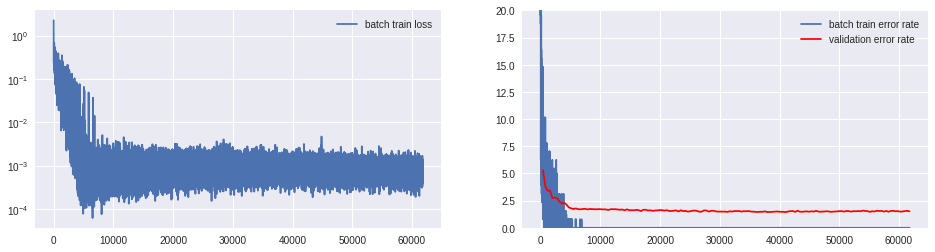

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 1000),
     TanhLayer(),
     DropoutLayer(0.5),
     AffineLayer(1000, 500),
     TanhLayer(),
     DropoutLayer(0.5),
     AffineLayer(500, 100),
     TanhLayer(),
     DropoutLayer(0.2),        
     AffineLayer(100, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

model.train_mode()
# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=100, device='cuda')
model.eval_mode()
print ("Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test']))

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

## This is training for Problem 4 with data augmentation. 
Data loaded in cell Starter code for MNIST and SGD scaffolding

Training the model!
Interrupt at any time to evaluate the best validation model so far.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Minibatch    100  | loss  1.03 | err rate 32.03%, steps/s 30.52
alpha 0.090909

Minibatch    200  | loss  1.15 | err rate 33.59%, steps/s 64.88
alpha 0.090909

Minibatch    300  | loss  0.86 | err rate 27.34%, steps/s 95.71
alpha 0.090909

----------------------------------------------------------
After epoch  1 | valid err rate: 19.44% | doing 100 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.88 | err rate 26.56%, steps/s 80.90
alpha 0.083333

Minibatch    500  | loss  0.85 | err rate 25.00%, steps/s 156.40
alpha 0.083333

Minibatch    600  | loss  0.59 | err rate 18.75%, steps/s 194.08
alpha 0.083333

Minibatch    700  | loss  0.67 | err rate 18.75%, steps/s 226.36
alpha 0.083333

----------------------------------------------------------
After epoch  2 | valid err rate: 13.29% | doing 100 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.78 | err rate 25.00%, steps/s 159.37
alpha 0.076923

Mi

Process Process-9234:
Process Process-9231:
Process Process-9239:
Process Process-9240:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-9233:
Process Process-9238:
Process Process-9232:
Process Process-9237:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-9235:
Process Process-9236:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run



Loading best params on validation set (epoch 728)



  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py", line 660, in affine
    return img.transform(output_size, Image.AFFINE, matrix, resample, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
KeyboardInterrupt
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 1896, in transform
    extension, if possible.
  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = self.transform(img)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
 

Test error rate: 0.58%


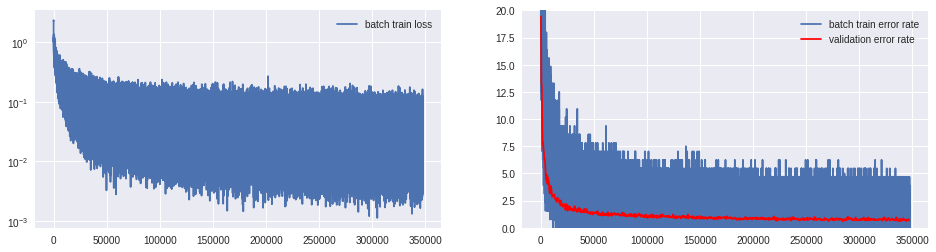

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1000),
     TanhLayer(),
     DropoutLayer(0.5),
     AffineLayer(1000, 500),
     TanhLayer(),
     DropoutLayer(0.5),
     AffineLayer(500, 100),
     TanhLayer(),
     DropoutLayer(0.2),        
     AffineLayer(100, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

model.train_mode()
# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=100, device='cuda')
model.eval_mode()
print ("Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test']))

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.

# Problem 8: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.